In [48]:
## Loading Libraries
import pandas as pd
import numpy as np
import networkx as nx
import pickle
import matplotlib.pyplot as plt 
from random import uniform
from copy import deepcopy
from scipy.interpolate import UnivariateSpline
import warnings

# Printing All Results
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%load_ext line_profiler
%load_ext memory_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [11]:
## Line profiling the simulatin function
# %lprun -f Simulate_Time Simulate_Time(deepcopy(G))

In [4]:
path=r'C:\Users\Mahdi\COVID19-Simulation\CreatingGraphs-IndianVillages\Results'
with open(path+"\GraphList_Multi", 'rb') as fp:
     MultiGraphList = pickle.load(fp)
    
## Creating the transimmsion graph based on the multigraph to run the simulatin on
def TransmissionGraph(Data=MultiGraphList,Labels=["Money","Visit","Kerosene","Temple"],P=[0.2,0.3,0.1,0.25],
                 dropEdge="",dropNode="",dropTop=0):
        
        # Initilizing output 
        out = list()
        # For every Graph in GraphList
        for G in Data:
            if len(dropNode)!=0:
                ############# Filtering Nodes #############
                # A dictionary of the node and the specific characteristics by which we want to filter
                listNodeAttr = nx.get_node_attributes(G,name=dropNode)
                # Find the threshold for that characteristics. Edges from a node with larger char, will drop.
                threshold = np.percentile(list(listNodeAttr.values()),100-dropTop)
                # List of nodes that must be quarantined!
                DropList = [k for k,v in listNodeAttr.items() if v>threshold ]
                # Removing edges from that node. Quarantining!
                for node in DropList:
                    edgelist = list(G.edges(node))
                    G.remove_edges_from(edgelist)

            
            ########### Filtering Edges #############
            if len(dropEdge)!=0:
                # Iterating over all edges
                for u,v,key,atrr in list(G.edges(data=True,keys=True)):
                    # If the edge has a attribute which is in dropEdge list:
                    if (atrr['label'] in  dropEdge) :
                        # We remove that edge
                        G.remove_edge(u,v,key=key)

  
            ############# Correcting the weights of Edges #############
            for u,v,key,atrr in list(G.edges(data=True,keys=True)):
                # Finding location of leble in list --> finding p
                weight = P[Labels.index(atrr['label'])]
                # changing the weight
                G[u][v][key]['weight'] = weight
                
     
            ############# Calculating overall transmission probability #############
            # Iterating over each two nodes that there is at least 1 edge between
            for (u,v) in list(set(G.edges())):
                # Keys : number of edges between this two nodes
                keys = list(G.get_edge_data(u,v).keys())
                # 1 - Transimision probability : each element for one edge
                noTransProb = [(1-G[u][v][i]['weight']) for i in keys]
                # The probability that at least one of the edges infects other people
                newWeight = np.round(1-np.prod(noTransProb),3)
                # Removind old edges: key by key
                for i in keys:
                    G.remove_edge(u,v,key=i)
                # Add new edge, which weight shows the transmission probability
                G.add_edges_from([(u,v)],weight=newWeight)
                
                
                
            # Appending modified Graph    
            out.append(nx.Graph(G))
        
        # Returning output
        return(out)

In [5]:
############################################################################################################################
#########################################       Functions        ###########################################################
############################################################################################################################

In [2]:
## Creating Random Seeds

def generateRandSeed(num,size):
    NodeList=np.array(list(range(size))) 
    out=np.random.choice(NodeList,num,replace=False)    
    return(out)
    

In [3]:
## Deviding a list in to some parts
def chunkIt(seq, num):
    avg = len(seq) / float(num)
    out = []
    last = 0.0

    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg

    return out

In [214]:
def Simulate_Time (G,Maximum_Time=100,Seasons=chunkIt(list(range(1,1000)),4),P_seasons = [1,1,1,1],
                  Seeds = [0,7], n_dr=1, q_die=0.2, n_s=1, q_s=0.1, pnt_cond=False, how='Transmission',
                  network_update = False):
    
    if n_s>n_dr:
        warnings.warn("n_s(time to show symptoms) should be less than n_dr(time to die or recovers)")
    
    
    # Size of Graph
    lng = G.number_of_nodes()
    if pnt_cond:
        print("Number of nodes are:",lng," and the number of edges are:",G.number_of_edges())

    OUT=list()
    
        
    ## Creating Neighbor List##
    Neighbors_List = []
    Neighbors_org= []
    Nodes = list(G.nodes())
    Nodes.sort(reverse=False)
    # Finding Neighbors of each node
    for node in list(Nodes):
        Neighbors_List.append(dict(G.adj[node]))
        Neighbors_org.append(dict(G.adj[node]))
    
        
    ## Initializing the Status Lists ##   
    Normal = list(range(lng))
    Infected = list()
    Died = list()
    Recovered = list()
    
    # Adding initial seeds to infected list
    Infected = [x for x in Seeds]
    if pnt_cond:
        print("Infecteds are     :",Infected)
    
    # Timer for infecteds
    Infected_timer = [0]*len(Seeds)
    if pnt_cond:
        print("Infecteds timer   :",Infected_timer)
    
    # Removing infecteds from Normal list
    for node in Infected:
        Normal.remove(node)
    if pnt_cond:
        print("Normals are       :",Normal)

        
        
    ## Declaring output lists ##
    R0_Node_list = [0]*lng

    # Declaring level lists
    Normal_size =[]
    Infected_size =[]
    Recovered_size =[]
    Died_size =[]
    
    # Setting first elements
    Normal_size.append(len(Normal))
    Infected_size.append(len(Seeds))
    Recovered_size.append(0)
    Died_size.append(0)



    ## Going through time ##
    for t in range(1,Maximum_Time):
        
        # If there is no Infected we are on steady state. So quit!
        if len(Infected)==0:
            break
        
        # Print
        if pnt_cond:
            print("\n\n\n************************** Time "+ str(t) +" ****************************")                  
    
    
        ## Finding Season ##
        if t in Seasons[0]:
            p_s = P_seasons[0]
        elif t in Seasons[1]:
            p_s = P_seasons[1]
        elif t in Seasons[2]:
            p_s = P_seasons[2]
        elif t in Seasons[3]:
            p_s = P_seasons[3]
        else:
            p_s = 1

        if pnt_cond:
            print("Infecteds are     :",Infected)
            print("Infecteds timer   :",Infected_timer)  
            print("\n*******  Level 1: DieRecover")
    
        ## Finding nodes that must die or recover ##            
        DieRecover = [x for x,y in zip(Infected,Infected_timer) if y == n_dr]
        if pnt_cond:
            print("DieRecover are     :",DieRecover)
        
        if network_update:
            # Finding nodes that their neighbor just died or recovered so their neighbor list must be updated.
            nhbr_rd = set()
            for node in DieRecover:
                nhbr_rd = nhbr_rd.union(G.adj[node])
            
        
        # For each node which the timer has reached certain lavel:
        for node in DieRecover:    
            # We delete that node from infecteds and timer
            index = Infected.index(node)
            del Infected_timer[index]
            del Infected[index]
            
            if network_update:
                ## Remove the edges from that node (Recovereds can not get sick again) ##
                G.remove_edges_from(list(G.edges(node)))

            
            # We see they die or recover with respect to q_die
            if uniform(0,1) < q_die:
                # It dies
                Died.append(node)
                if pnt_cond:
                    print("  Node ",node," Died!")
            else:
                # It recovers
                Recovered.append(node)
                if pnt_cond:
                    print("  Node ",node," Recovered!")
        
        
        
        if network_update:
            ## Updating Neighbor List
            for neighbor in nhbr_rd:
                Neighbors_List[neighbor] = dict(G.adj[neighbor]) 
        
        # Print
        if pnt_cond:
            print("Infecteds are      :",Infected)
            print("Infecteds timer    :",Infected_timer)
            print("Normal are         :",Normal)
            print("Recovered are      :",Recovered)
            print("Died are           :",Died)
            print("\n*******  Level 2: Propagation")


            
        

        ## finding new infected nodes ##
        # New infected nodes in each time step
        New_Infected = []
        # For each Infected node we try to find the transmissions
        for i in range(len(Infected)):
            if pnt_cond:
                print("\nInfecteds are      :",Infected)
            
            # Chossing node
            node = Infected[i]
            # Number of Transmission for each node in each time
            R0 = 0
            
            # Checking if the node has symptoms
            if Infected_timer[i] < n_s:
                Q = 1
            else:
                Q = q_s
            if pnt_cond:
                print("Node ",node," is selected and it has no symptom: ",Q==1)

            
            ## Finding the Neighbors of the node based on the how (transmission or new infection)
            if how=='Transmission':
                Neighbors = Neighbors_List[node]
            elif how=='New_Infection':
                Neighbors = {k:v for k,v in Neighbors_List[node].items() if k in Normal}
            else:
                raise ValueError('"how" can get modes: Transmission, New_Infection')
            if pnt_cond:
                    print("  Neighbors of node ",node," are ",list(Neighbors),'Method: ',how,
                          ', all neighbors are:',list(Neighbors_org[node]))
                    
            
            # for each neighbor (already informed or not informed)
            for advicee in Neighbors:
                if pnt_cond:
                    print("    *Neighbor ",advicee," is selected and R0 is: ",R0)

                # Gets informed with respect to edge probability
                if  uniform(0,1)<Neighbors[advicee]['weight']*Q*p_s:
                    # Increasing the R-0
                    R0+=1
                    if pnt_cond:
                        print("        _Node ",advicee," has recieved and R0 is: ",R0,
                              ", and this node is already in Infected of New_Infected:",
                              advicee not in Normal)

                    # If its a new node (which is not already informed) we update the list of informeds
                    if advicee in Normal:
                        Normal.remove(advicee)
                        New_Infected.append(advicee)
                        if pnt_cond:
                            print("        Normal is        :",Normal)
                            print("        New Infectd is   :",New_Infected)
            

            # Updating number of new infected for each node
            R0_Node_list[node] = R0_Node_list[node]+R0
            if pnt_cond ==1:
                print("R0_List is: ",R0_Node_list)
        
         

        ## Increasing Timer of nodes ##
        Infected_timer = [x+1 for x in Infected_timer]
        
        # Updating Infected list and the timer
        Infected = Infected + New_Infected
        Infected_timer = Infected_timer + len(New_Infected)*[0]
        
        if pnt_cond:
            print("\n\n     Infectd is       :",Infected)
            print("     Infectd_timer is :",Infected_timer,"\n")


        # Updating level sizes in each step
        Normal_size.append(len(Normal))
        Infected_size.append(len(Infected))
        Recovered_size.append(len(Recovered))
        Died_size.append(len(Died))
        
        
        
        
        
    
    # Keeping elements of the node list which are not normal
    R0_Infected_Nodes = {k:R0_Node_list[k] for k in range(len(R0_Node_list)) if k not in Normal}
    
    # The level outpu
    level = pd.DataFrame(data={'time':list(range(len(Normal_size))),
                            'Normal':Normal_size,
                            'Infected':Infected_size,
                            'Recovered':Recovered_size,
                            'Died':Died_size})
    
    OUT.append(level)
    OUT.append(R0_Infected_Nodes)
    OUT.append(np.mean(list(R0_Infected_Nodes.values())))
    OUT.append((len(Died)+len(Recovered))/lng)

    
    return(OUT)

In [212]:
n = 1000
d = 4
G_Erdos = nx.erdos_renyi_graph(n,d/n)
edge_weight = dict(zip(G_Erdos.edges(),[0.4 for x in range(len(G_Erdos.edges()))]))
nx.set_edge_attributes(G_Erdos,edge_weight,'weight')

In [213]:
# %%time
a = Simulate_Time (deepcopy(G_Erdos),Maximum_Time=100,Seasons=chunkIt(list(range(1,1000)),4),P_seasons = [1,1,1,1],
                   Seeds = [0,1], n_dr=1, q_die=0.2, n_s=1, q_s=0.1, 
                   pnt_cond=0, how='Transmission',network_update = True)
a[2]
a[0]

1.1535087719298245

,time,Normal,Infected,Recovered,Died
0,0,998,2,0,0
1,1,996,4,0,0
2,2,993,5,1,1
3,3,989,7,3,1
4,4,982,11,5,2
5,5,972,17,7,4
6,6,957,25,12,6
7,7,935,37,19,9
8,8,905,52,33,10
9,9,851,84,49,16


In [164]:
a[0]

,time,Normal,Infected,Recovered,Died,New_Infected,New_Died
0,0,8,2,0,0,NaN,NaN
1,1,5,5,0,0,3.0,0.0
2,2,2,6,2,0,3.0,0.0
3,3,2,3,3,2,0.0,2.0
4,4,2,0,5,3,0.0,1.0


In [165]:
%lprun -f Simulate_Time Simulate_Time(deepcopy(G_Erdos))

Timer unit: 1e-07 s

Total time: 0.0208492 s
File: <ipython-input-163-176d626c7fdf>
Function: Simulate_Time at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def Simulate_Time (G,Maximum_Time=100,Seasons=chunkIt(list(range(1,1000)),4),P_seasons = [1,1,1,1],
     2                                                             Seeds = [0,7], n_dr=1, q_die=0.2, n_s=1, q_s=0.1, pnt_cond=False, how='Transmission',
     3                                                             network_update = True):
     4                                               
     5         1        108.0    108.0      0.1      if n_s>n_dr:
     6                                                   warnings.warn("n_s(time to show symptoms) should be less than n_dr(time to die or recovers)")
     7                                               
     8                                               
     9                                        

In [9]:
############################################################################################################################
##########################################       Simulation        #########################################################
############################################################################################################################

In [13]:
village_id = 57
Nofilter = TransmissionGraph(Data=[deepcopy(MultiGraphList[village_id])],dropNode="",dropTop=0,dropEdge="",
                                        Labels=["Money","Visit","Kerosene","Temple"],P=[0.04,.06,0.02,0.05])
G1 = deepcopy(Nofilter[0])


_visit = TransmissionGraph(Data=[deepcopy(MultiGraphList[village_id])],dropNode="",dropTop=0,dropEdge=["Visit"],
                                        Labels=["Money","Visit","Kerosene","Temple"],P=[0.08,.12,0.04,0.1])
G2 = deepcopy(_visit[0])


_temple = TransmissionGraph(Data=[deepcopy(MultiGraphList[village_id])],dropNode="",dropTop=0,dropEdge=["Temple"],
                                        Labels=["Money","Visit","Kerosene","Temple"],P=[0.08,.12,0.04,0.1])
G3 = deepcopy(_temple[0])


_money = TransmissionGraph(Data=[deepcopy(MultiGraphList[village_id])],dropNode="",dropTop=0,dropEdge=["Money"],
                                        Labels=["Money","Visit","Kerosene","Temple"],P=[0.08,.12,0.04,0.1])
G4 = deepcopy(_money[0])

_temple_visit = TransmissionGraph(Data=[deepcopy(MultiGraphList[village_id])],dropNode="",dropTop=0,dropEdge=["Visit","Temple"],
                                        Labels=["Money","Visit","Kerosene","Temple"],P=[0.08,.12,0.04,0.1])
G5 = deepcopy(_temple_visit[0])

In [53]:
# %%time
# Erdos
range_size = 10
Gc_Erdos = list()
for i in range(range_size):
    graph_size = 1000
    G_Erdos = nx.erdos_renyi_graph(graph_size,0.02)
    edge_weight = dict(zip(G_Erdos.edges(),[uniform(0.02,0.16) for x in range(len(G_Erdos.edges()))]))
    nx.set_edge_attributes(G_Erdos,edge_weight,'weight')

    Gc_Erdos.append(deepcopy(G_Erdos))


# Power-Law Grapj
#create a graph with degrees following a power law distribution
Gc_pl = list()
cnt=0
while cnt <10:
    print(cnt)
    try:
        s = nx.utils.powerlaw_sequence(graph_size, 1.25) #100 nodes, power-law exponent 2.5
        G_pl = nx.expected_degree_graph(s, selfloops=False)
    except ZeroDivisionError:
            continue
    if G_pl.number_of_edges()>9000 and G_pl.number_of_edges()<10000:
        edge_weight = dict(zip(G_pl.edges(),[uniform(0.02,0.16) for x in range(len(G_pl.edges()))]))
        nx.set_edge_attributes(G_pl,edge_weight,'weight')
        Gc_pl.append(deepcopy(G_pl))
        cnt+=1
    else:
        continue
    

#draw and show graph
# pos = nx.spring_layout(G)
# nx.draw_networkx(G, pos)
# plt.show()

Gc_Erdos[0].number_of_edges()
Gc_pl[0].number_of_edges()

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9


9891

9021

In [56]:
for x in Gc_Erdos:
    x.number_of_edges()

for x in Gc_pl:
    x.number_of_edges()

9891

10012

9998

9917

10096

9979

10106

10070

9902

10131

9021

9078

9816

9522

9751

9773

9944

9219

9468

9478

In [58]:
G = deepcopy(G1)
G.number_of_nodes()
G.number_of_edges()

lng = G.number_of_nodes()

seedSize = 3
seedRPT = 5
RPT = 5

R0_X = 0
R0_X_Time= list()
levels_X = list()
time_end_X = []


R0_Y = 0
R0_Y_Time = list()
levels_Y = list()
time_end_Y = []


for x,y in (Gc_Erdos, Gc_pl):
    for s in range(seedRPT):
        print(s)
        Seeds = generateRandSeed(seedSize,lng)

        for rpt in range(RPT):
    #         deepcopy(G).number_of_edges()
            X = Simulate_Time (deepcopy(G),Maximum_Time=120,End='Steay',Seasons=chunkIt(list(range(1,100)),4),P_seasons = [0.7,1.4,1,0.7],
                      Seeds = Seeds, n_dr=20, q_die=0.3, n_s=10, q_s=0.2, pnt_cond=0, how='Transmission')

            Y = Simulate_Time (deepcopy(G),Maximum_Time=120,End='Stedy',Seasons=chunkIt(list(range(1,100)),4),P_seasons = [0.1,1.4,1,0.7],
                      Seeds = Seeds, n_dr=20, q_die=0.3, n_s=10, q_s=0.2, pnt_cond=0, how='Transmission')

            R0_X = R0_X+X[3]
            R0_X_Time.append(X[1])
            time_end_X.append(X[4])
            levels_X.append(X[0])


            R0_Y = R0_Y+Y[3]
            R0_Y_Time.append(Y[1])
            time_end_Y.append(Y[4])
            levels_Y.append(Y[0])
        
R0_X_Node = R0_X/(seedRPT*RPT*10)

R0_Y_Node = R0_Y/(seedRPT*RPT*10)

356

1153

ValueError: too many values to unpack (expected 2)

Wall time: 191 ms


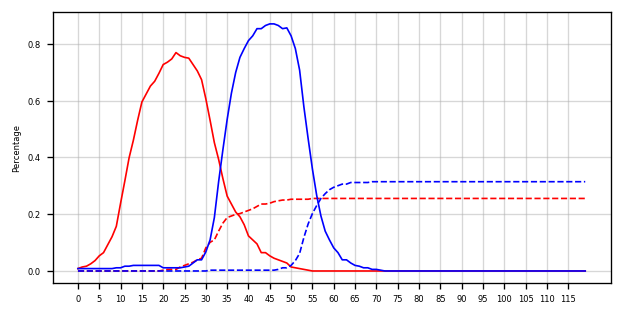

In [15]:
%%time
num=5
# i=time_end.index(max(time_end))
i = 19
data_X = levels_X[i]
N = 10

y1_X = data_X.time

y2_X = [x/lng for x in data_X.Infected]
# y2 = np.convolve(y2,np.ones((N,))/N,mode='same')

y3_X = [x/lng for x in data_X.Died]
# y3 = np.convolve(y3,np.ones((N,))/N,mode='same')




# Plot Line1 (Left Y Axis)
fig, ax1 = plt.subplots(1,1,figsize=(6,3), dpi= 120)

ax1.plot(y1_X,y2_X,color='red',lw=1,label='Infected')
ax1.plot(y1_X, y3_X,color='red',lw=1,label='Died',ls='dashed')
ax1.tick_params(axis='x', labelsize=5)
ax1.set_ylabel('Percentage', fontsize=5)
ax1.tick_params(axis='y', rotation=0,labelsize=5 )
ax1.set_xticks(y1_X[::5])
ax1.set_xticklabels(y1_X[::5])
ax1.grid(alpha=.4)



data_Y = levels_Y[i]

y1_Y = data_Y.time

y2_Y = [x/lng for x in data_Y.Infected]
# y2 = np.convolve(y2,np.ones((N,))/N,mode='same')

y3_Y = [x/lng for x in data_Y.Died]
# y3 = np.convolve(y3,np.ones((N,))/N,mode='same')


ax1.plot(y1_Y,y2_Y,color='blue',lw=1,label='Infected')
ax1.plot(y1_Y, y3_Y,color='blue',lw=1,label='Died',ls='dashed')
ax1.tick_params(axis='x', labelsize=5)
ax1.set_ylabel('Percentage', fontsize=5)
ax1.tick_params(axis='y', rotation=0,labelsize=5 )
ax1.set_xticks(y1_Y[::5])
ax1.set_xticklabels(y1_Y[::5])
ax1.grid(alpha=.5)

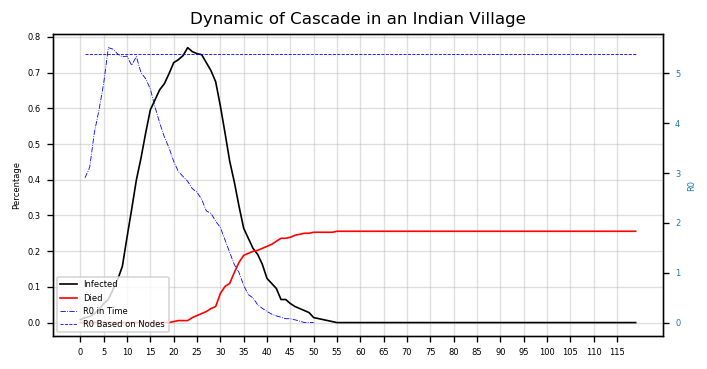

Wall time: 1.01 s


In [19]:
%%time
num=5
# i=time_end.index(max(time_end))
i = 19
data = levels_X[i]
N = 10

y1 = data.time

y2 = [x/lng for x in data.Infected]
# y2 = np.convolve(y2,np.ones((N,))/N,mode='same')

y3 = [x/lng for x in data.Died]
# y3 = np.convolve(y3,np.ones((N,))/N,mode='same')

R1 = R0_X_Time[i]
R1 = np.convolve(R1,np.ones((N,))/N,mode='same')



# Plot Line1 (Left Y Axis)
fig, ax1 = plt.subplots(1,1,figsize=(6,3), dpi= 120)

ax1.plot(y1,y2,color='black',lw=1,label='Infected')
ax1.plot(y1, y3,color='red',lw=1,label='Died')
ax1.tick_params(axis='x', labelsize=5)
ax1.set_ylabel('Percentage', fontsize=5)
ax1.tick_params(axis='y', rotation=0,labelsize=5 )
ax1.set_xticks(y1[::5])
ax1.set_xticklabels(y1[::5])
ax1.grid(alpha=.4)


ax2 = ax1.twinx()
ax2.plot(y1[1:],R1,color='blue',lw=0.5,ls='-.',label='R0 in Time')    
ax2.plot(y1[1:],[R0_X_Node]*len(y1[1:]),color='blue',lw=0.5,ls='dashed',label='R0 Based on Nodes')
ax2.set_ylabel("R0", color='tab:blue', fontsize=5)
ax2.tick_params(axis='y', labelcolor='tab:blue',labelsize=5)
fig.tight_layout()

plt.title('Dynamic of Cascade in an Indian Village',fontsize=10)

handles,labels = [],[]
for ax in fig.axes:
    for h,l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)
plt.legend(handles,labels,fontsize=5)

plt.show()